In [1]:
import logging

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import colors
import photutils
from photutils.datasets import make_4gaussians_image
from photutils.morphology import centroid_com, centroid_1dg, centroid_2dg
from photutils.morphology import data_properties
from photutils import properties_table, EllipticalAperture
from astropy.stats import sigma_clipped_stats

from k2spin import lc
from k2spin import k2io
from k2spin import plot
from k2phot import tpf_io
from k2phot import centroid


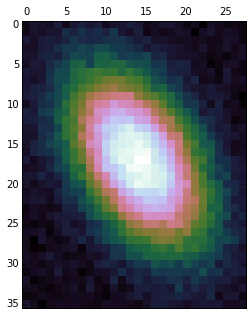

In [2]:
data = make_4gaussians_image()[43:79, 76:104]
plt.matshow(data, cmap="cubehelix")

In [3]:
x1, y1 = centroid_com(data)
print x1, y1

13.9315799834 17.0512344411


In [4]:
x2, y2 = centroid_1dg(data)
print x2, y2 

14.0403527074 16.9623064636


In [5]:
x3, y3 = centroid_2dg(data)
print x3, y3

14.0022120737 16.996134593


(0, 35)

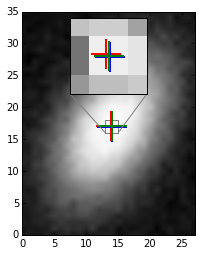

In [6]:
fig, ax = plt.subplots(1, 1)
ax.imshow(data, origin='lower', cmap='Greys_r')
marker = '+'
ms, mew = 30, 2.
plt.plot(x1, y1, color='red', marker=marker, ms=ms, mew=mew)
plt.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
ax2 = zoomed_inset_axes(ax, zoom=6, loc=9)
ax2.imshow(data, interpolation='nearest', origin='lower',
           cmap='Greys_r', vmin=190, vmax=220)
ax2.plot(x1, y1, color='red', marker=marker, ms=ms, mew=mew)
ax2.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
ax2.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
ax2.set_xlim(13, 15)
ax2.set_ylim(16, 18)
mark_inset(ax, ax2, loc1=3, loc2=4, fc='none', ec='0.5')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax.set_xlim(0, data.shape[1]-1)
ax.set_ylim(0, data.shape[0]-1)

In [7]:
x5, y5 = centroid.daofind_centroid(data)
x6, y6 = centroid.flux_weighted_centroid(data, 25, init=(x1,y1))
print x5, y5
print x6, y6

xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--------- --------- --------- ---------- ---------- ---- --- ---- ---- --- 0
17.2009779682 13.5419455122


(0, 35)

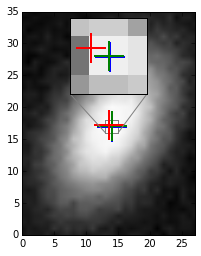

In [8]:
fig, ax = plt.subplots(1, 1)
ax.imshow(data, origin='lower', cmap='Greys_r')
marker = '+'
ms, mew = 30, 2.
plt.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
plt.plot(y6, x6, color='red', marker=marker, ms=ms, mew=mew)
ax2 = zoomed_inset_axes(ax, zoom=6, loc=9)
ax2.imshow(data, interpolation='nearest', origin='lower',
           cmap='Greys_r', vmin=190, vmax=220)
plt.plot(x2, y2, color='blue', marker=marker, ms=ms, mew=mew)
plt.plot(x3, y3, color='green', marker=marker, ms=ms, mew=mew)
ax2.plot(y6, x6, color='red', marker=marker, ms=ms, mew=mew)
ax2.set_xlim(13, 15)
ax2.set_ylim(16, 18)
mark_inset(ax, ax2, loc1=3, loc2=4, fc='none', ec='0.5')
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)
ax.set_xlim(0, data.shape[1]-1)
ax.set_ylim(0, data.shape[0]-1)

xcentroid ycentroid sharpness roundness1 roundness2 npix sky peak flux mag
--------- --------- --------- ---------- ---------- ---- --- ---- ---- --- 0


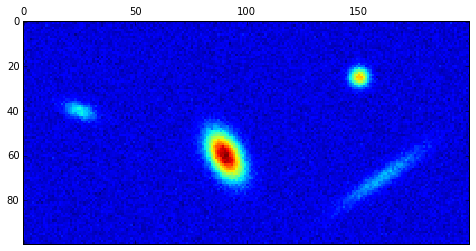

In [9]:
data2 = make_4gaussians_image()
coords, nc = centroid.daofind_centroid(data2)
print coords, nc
plt.matshow(data2)

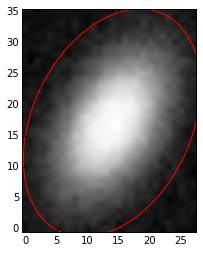

In [10]:
props = data_properties(data)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = properties_table(props, columns=columns)
r = 2.5    # approximate isophotal extent
position = (props.xcentroid.value, props.ycentroid.value)
a = props.semimajor_axis_sigma.value * r
b = props.semiminor_axis_sigma.value * r
theta = props.orientation.value
apertures = EllipticalAperture(position, a, b, theta=theta)
plt.imshow(data, origin='lower', cmap='Greys_r')
apertures.plot(color='red')

In [11]:
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
def find_ellip(filename, r=3, cutout_kwargs=None):
    """
    Compute properties of an image (basically fit a 2D Gaussian) and
    determine the corresponding elliptical aperture. 
    
    inputs:
    -------
    filename: string
    
    r: float
        isophotal extent (multiplied by semi-major axes of fitted
        gaussian to determine the elliptical aperture)
        
    extents: array-like, optional
        xmin, xmax, ymin, ymax of sub-image
    """
    table, times, pixels, maskmap, maskheader = tpf_io.get_data(filename)
    if cutout_kwargs is None:
        coadd = np.sum(pixels, axis=0)
        cmask = (maskmap==0)
    else:
        coadd = np.sum(pixels, axis=0)
        cmask = (maskmap==0)
        coadd, cmask, cerr, cslice = photutils.morphology.cutout_footprint(coadd, mask=cmask, **cutout_kwargs)
    mean, median, std = sigma_clipped_stats(coadd, mask=cmask, sigma=3.0, iters=3)
    cprops = data_properties(coadd - median, mask=cmask, background = median)
    tbl = properties_table(cprops, columns=columns)
    print tbl
    position = (cprops.xcentroid.value, cprops.ycentroid.value)
    a = cprops.semimajor_axis_sigma.value * r
    b = cprops.semiminor_axis_sigma.value * r
    theta = cprops.orientation.value
    apertures = EllipticalAperture(position, a, b, theta=theta)
    plt.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
    apertures.plot(color='red')

 id   xcentroid     ycentroid   ... semiminor_axis_sigma  orientation 
         pix           pix      ...         pix               rad     
--- ------------- ------------- ... -------------------- -------------
  1 8.47246749263 9.22942332198 ...        1.25156232207 1.18370555521


/home/stephanie/anaconda/lib/python2.7/site-packages/astropy/stats/sigma_clipping.py:140: RuntimeWarning: invalid value encountered in greater
  filtered_data.mask |= do * do > varfunc(filtered_data) * sig ** 2
/home/stephanie/anaconda/lib/python2.7/site-packages/photutils/segmentation.py:344: RuntimeWarning: invalid value encountered in greater
  cutout = np.where(cutout > 0, cutout, 0.)    # negative pixels -> 0


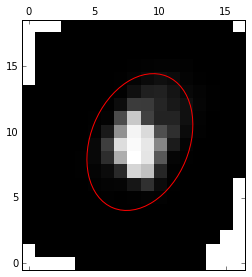

In [12]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202539362-c02_lpd-targ.fits.gz"
find_ellip(filename)

 id   xcentroid     ycentroid   ... semiminor_axis_sigma  orientation  
         pix           pix      ...         pix               rad      
--- ------------- ------------- ... -------------------- --------------
  1 5.85104218115 8.81300985517 ...        1.92721043976 0.206500266946


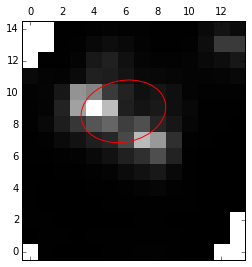

In [13]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202521690-c02_lpd-targ.fits.gz"
find_ellip(filename, r=1)#, extents=[4,10,6,10])

 id   xcentroid     ycentroid   ... semiminor_axis_sigma   orientation  
         pix           pix      ...         pix                rad      
--- ------------- ------------- ... -------------------- ---------------
  1 1.24369188716 2.04491551624 ...       0.445114841878 -0.514393815316


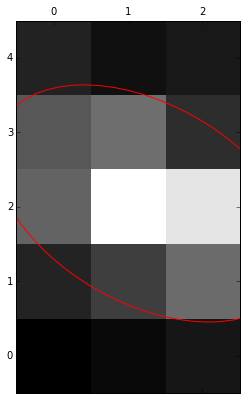

In [14]:
cutout_kwargs = {"position":(7,7),
                 "box_size":(5,3)}
find_ellip(filename, cutout_kwargs=cutout_kwargs)

In [47]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202521690-c02_lpd-targ.fits.gz"
table, times, pixels, maskmap, maskheader = tpf_io.get_data(filename)
coadd = np.sum(pixels, axis=0)
cmask = (maskmap==0)
mean, median, std = sigma_clipped_stats(coadd, mask=cmask, sigma=3.0, iters=3)
print median

1.9392e+06


In [48]:
sources, n = centroid.daofind_centroid(coadd)
print sources

 id   xcentroid     ycentroid   ...    peak         flux          mag      
--- ------------- ------------- ... ---------- ------------- --------------
  1 7.34787187823 7.15144263669 ... 49544876.0 35993.3119695 -11.3905545266
  2 4.03695747834 9.09692313334 ... 79667704.0 64553.5990898 -12.0248011518
  3 12.3517367874 12.9304317704 ... 16079732.0 14507.7711031 -10.4040017372


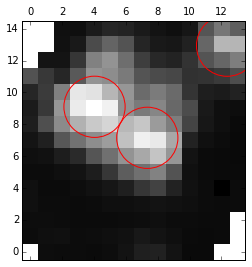

In [49]:
sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + (sources[0]["xcentroid"] - sources[1]["xcentroid"])**2)
r = sep / 2.0
apertures = photutils.CircularAperture((sources["xcentroid"], sources["ycentroid"]), r=r)
plt.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
apertures.plot(color='red')

In [51]:
flux1 = np.zeros(len(pixels))
flux2 = np.zeros(len(pixels))
pos1 = np.zeros(len(pixels)*2).reshape((-1,2))
pos2 = np.zeros(len(pixels)*2).reshape((-1,2))
for i, p in enumerate(pixels):
    mean, median, std = sigma_clipped_stats(p, mask=cmask, sigma=3.0, iters=3)
    sources, n = centroid.daofind_centroid(p)
    if n!=3:
        continue
    pos1[i,0] = sources[0]["xcentroid"]
    pos1[i,1] = sources[0]["ycentroid"]
    pos2[i,0] = sources[1]["xcentroid"]
    pos2[i,1] = sources[1]["ycentroid"]

    sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + (sources[0]["xcentroid"] - sources[1]["xcentroid"])**2)
    r = sep / 2.0
    apertures = photutils.CircularAperture((sources["xcentroid"], sources["ycentroid"]), r=r)
    phot_table = photutils.aperture_photometry(p - median, apertures)
    flux1[i] = phot_table["aperture_sum"][0]
    flux2[i] = phot_table["aperture_sum"][1]


/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()


(45000, 105000)

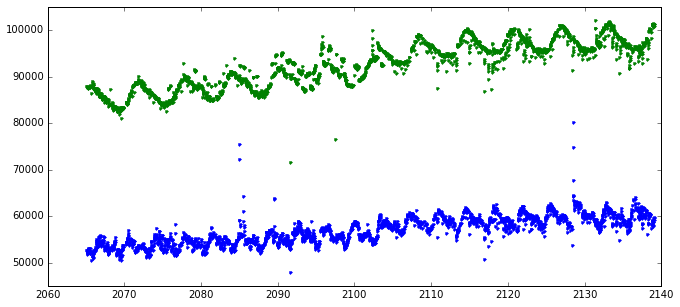

In [52]:
plt.figure(figsize=(11,5))
plt.plot(times[times>2065], flux1[times>2065], '.')
plt.plot(times[times>2065], flux2[times>2065], '.')
plt.ylim(45000,105000)

/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


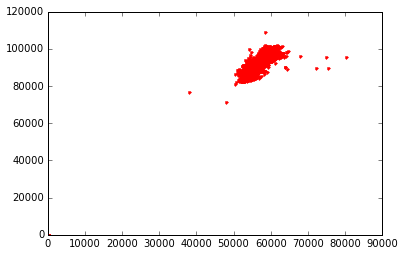

In [53]:
plt.plot(flux1[times>2065], flux2[times>2065], 'r.')

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ..., 
 [ 7.20384537  7.40709723]
 [ 7.07815854  7.43400616]
 [ 0.          0.        ]]
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ..., 
 [ 3.6913337   9.5061939 ]
 [ 3.59608574  9.55664988]
 [ 0.          0.        ]]


(6, 10)

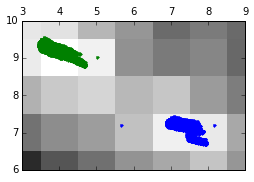

In [54]:
plt.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
print pos1
print pos2
plt.plot(pos1[:,0], pos1[:,1], 'b.')
plt.plot(pos2[:,0], pos2[:,1], 'g.')
plt.xlim(3,9)
plt.ylim(6,10)

That is a bit concerning - the centroid positions should track together for two stars on the same chip. 

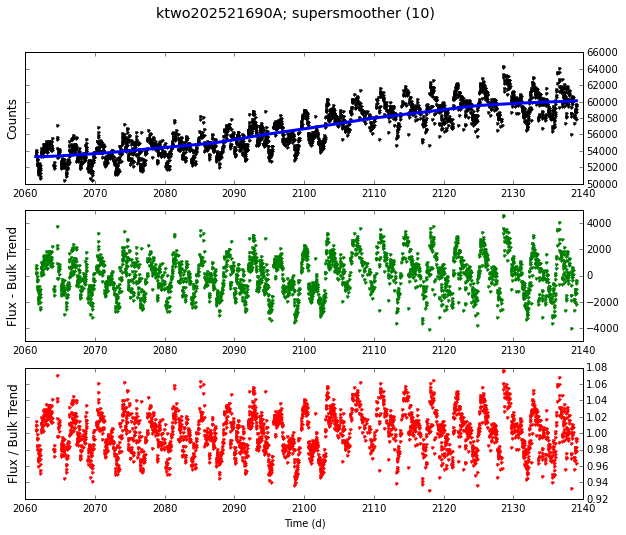

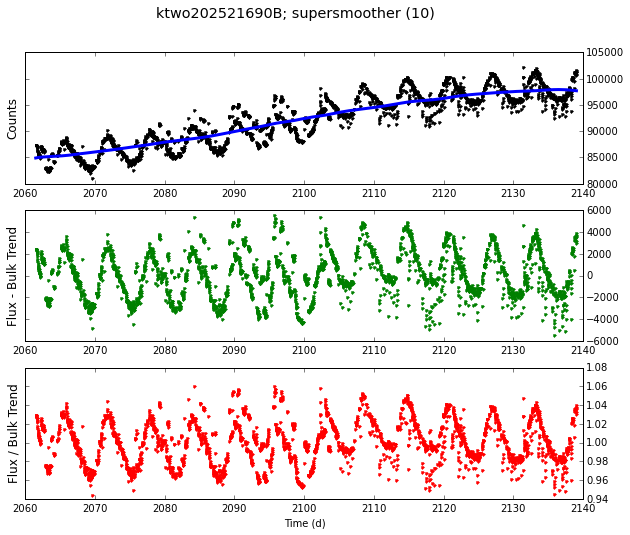

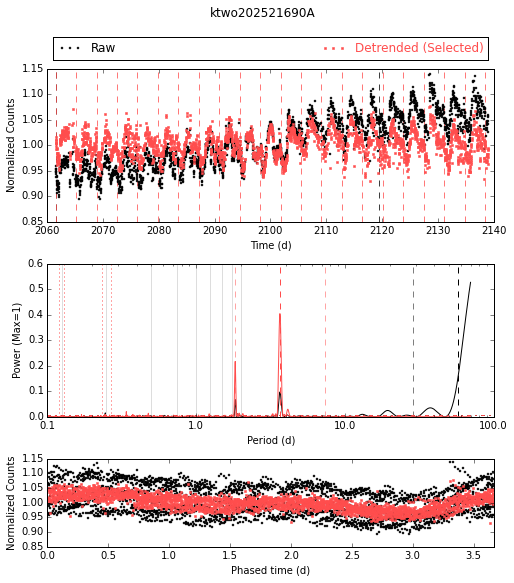

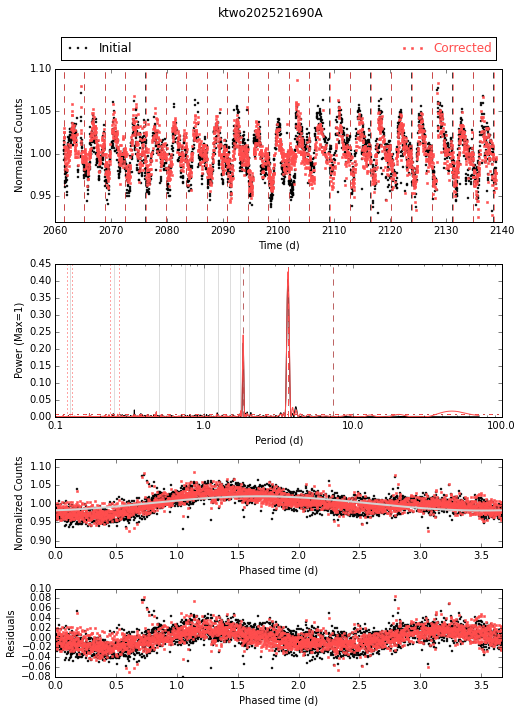

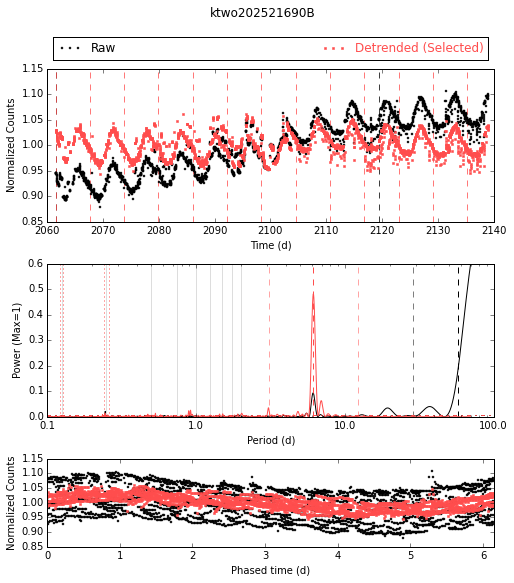

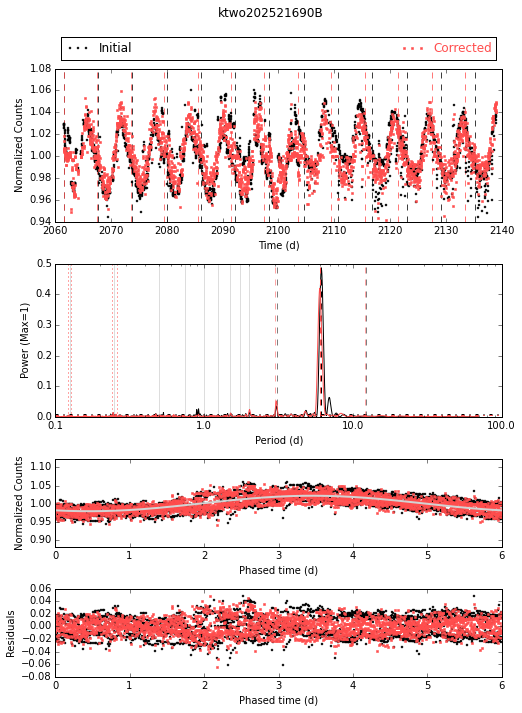

In [56]:
lc1 = lc.LightCurve(times, flux1, np.ones_like(flux1)*0.01, pos1[:,0], pos1[:,1], name="ktwo202521690A",
                    detrend_kwargs={"kind":"supersmoother","phaser":10})
lc2 = lc.LightCurve(times, flux2, np.ones_like(flux2)*0.01, pos2[:,0], pos2[:,1], name="ktwo202521690B",
                    detrend_kwargs={"kind":"supersmoother","phaser":10})

lc1.choose_initial()
lc1.correct_and_fit()

lc2.choose_initial()
lc2.correct_and_fit()

A (fainter) has a period of 3.5 d, while B (brighter) has a period of 6 d. They should be superimposed a bit, because the flux doesn't reach 0 between them so their PSFs are overlapping, but quite impressively you pretty much can't see the periods in each other's lightcurves. 

I don't know if iterative detrending ran on these, but probably not, since it just seems to blur the line a bit

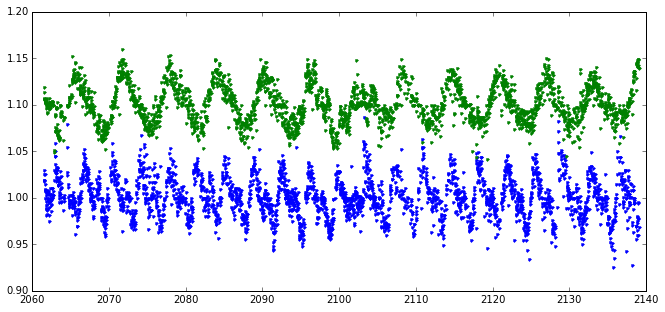

In [57]:
plt.figure(figsize=(11,5))
plt.plot(lc1.time, lc1.corrected_flux, '.')
plt.plot(lc2.time, lc2.corrected_flux+0.1,  '.')
#plt.ylim(45000,105000)

1.88401e+06
 id   xcentroid     ycentroid   ...    peak         flux           mag      
--- ------------- ------------- ... ---------- ------------- ---------------
  1 5.50163684366 3.15318177773 ... 11811645.0 1.50791415466 -0.445941544783
  2 5.56620914026 5.20225359111 ... 23050450.0  2.7767982354  -1.10886081169


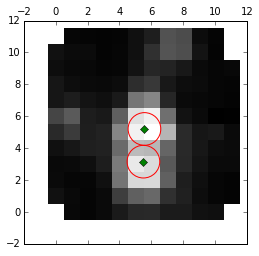

In [40]:
filename = "/home/stephanie/code/python/k2phot/tpf/ktwo202634644-c02_lpd-targ.fits.gz"
table, times, pixels, maskmap, maskheader = tpf_io.get_data(filename)
coadd = np.sum(pixels, axis=0)
cmask = (maskmap==0)
mean, median, std = sigma_clipped_stats(coadd, mask=cmask, sigma=3.0, iters=3)
print median
sources, n = centroid.daofind_centroid(coadd, daofind_kwargs={"threshold":3*median})
print sources
sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + (sources[0]["xcentroid"] - sources[1]["xcentroid"])**2)
r = sep / 2.0
positions = [[source["xcentroid"],source["ycentroid"]] for source in sources]
apertures = photutils.CircularAperture(positions, r=r)
plt.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
apertures.plot(color='red')
plt.plot(sources["xcentroid"], sources["ycentroid"], "gD")

In [41]:
flux1 = np.zeros(len(pixels))
flux2 = np.zeros(len(pixels))
pos1 = np.zeros(len(pixels)*2).reshape((-1,2))
pos2 = np.zeros(len(pixels)*2).reshape((-1,2))
bkgd = np.zeros(len(pixels))
for i, p in enumerate(pixels):
    mean, median, std = sigma_clipped_stats(p, mask=cmask, sigma=3.0, iters=3)
    sources, n = centroid.daofind_centroid(p)
    if n<2:
        continue
    elif sources[0]["xcentroid"]<2 or sources[0]["ycentroid"]<2:
        print i, sources
        continue
    pos1[i,0] = sources[0]["xcentroid"]
    pos1[i,1] = sources[0]["ycentroid"]
    pos2[i,0] = sources[1]["xcentroid"]
    pos2[i,1] = sources[1]["ycentroid"]

    bkgd[i] = median
    
    sep = np.sqrt((sources[0]["ycentroid"] - sources[1]["ycentroid"])**2 + (sources[0]["xcentroid"] - sources[1]["xcentroid"])**2)
    r = sep / 2.
    apertures = photutils.CircularAperture((sources["xcentroid"], sources["ycentroid"]), r=r)
    phot_table = photutils.aperture_photometry(p - median, apertures)
    flux1[i] = phot_table["aperture_sum"][0]
    flux2[i] = phot_table["aperture_sum"][1]


/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/home/stephanie/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


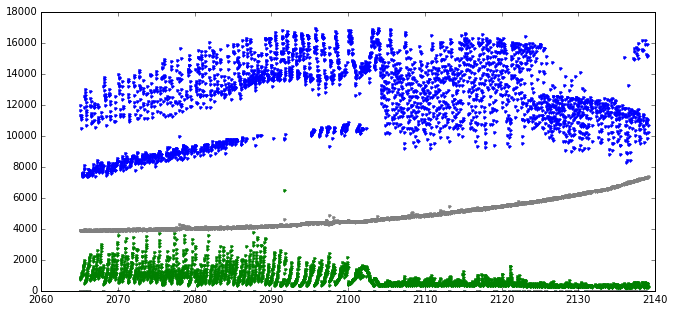

In [42]:
plt.figure(figsize=(11,5))
plt.plot(times[times>2065], flux1[times>2065], '.')
plt.plot(times[times>2065], flux2[times>2065], '.')
plt.plot(times[times>2065], bkgd[times>2065]*10, '.', color="grey")
#plt.ylim(45000,105000)

[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ..., 
 [ 5.75903728  3.62905203]
 [ 5.84313242  3.57309031]
 [ 5.90527246  3.54490599]]
[[ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 ..., 
 [ 5.95639115  5.28084935]
 [ 6.02985035  5.24213341]
 [ 6.09621589  5.20694467]]


(2, 6)

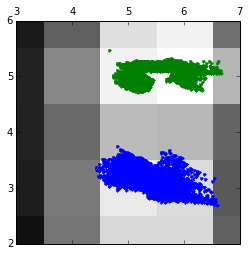

In [43]:
plt.matshow(coadd, origin='lower', cmap='Greys_r', norm=colors.LogNorm())
print pos1
print pos2
plt.plot(pos1[:,0], pos1[:,1], 'b.')
plt.plot(pos2[:,0], pos2[:,1], 'g.')
plt.xlim(3,7)
plt.ylim(2,6)

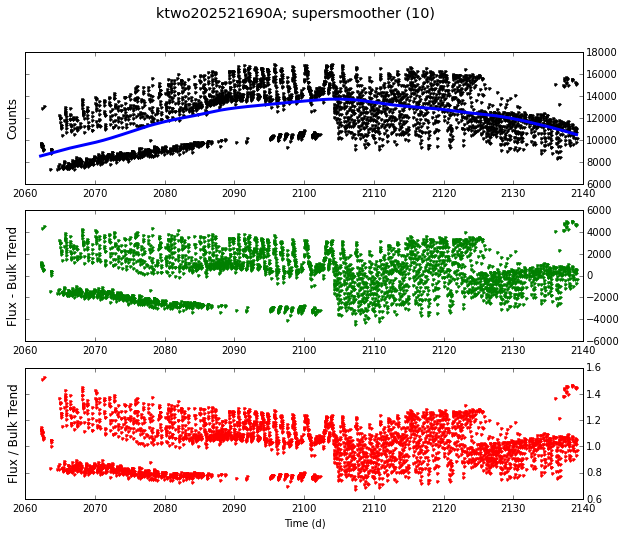

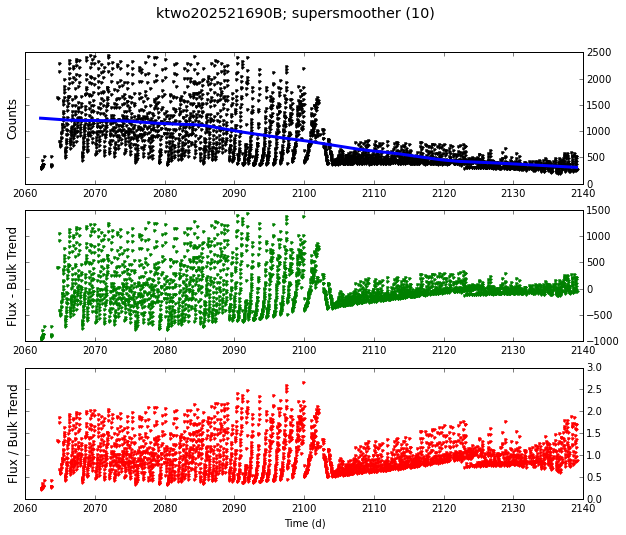

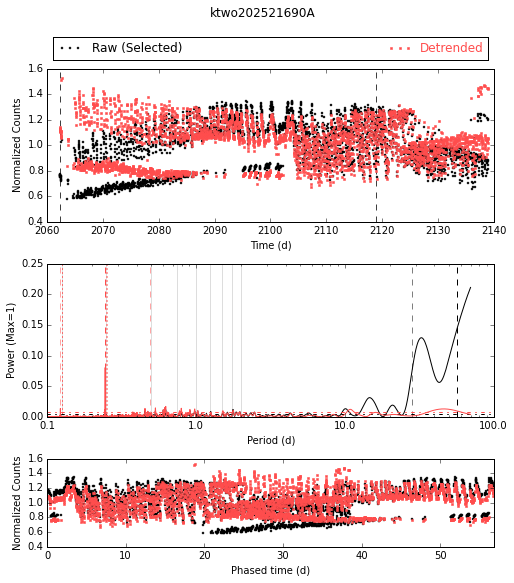

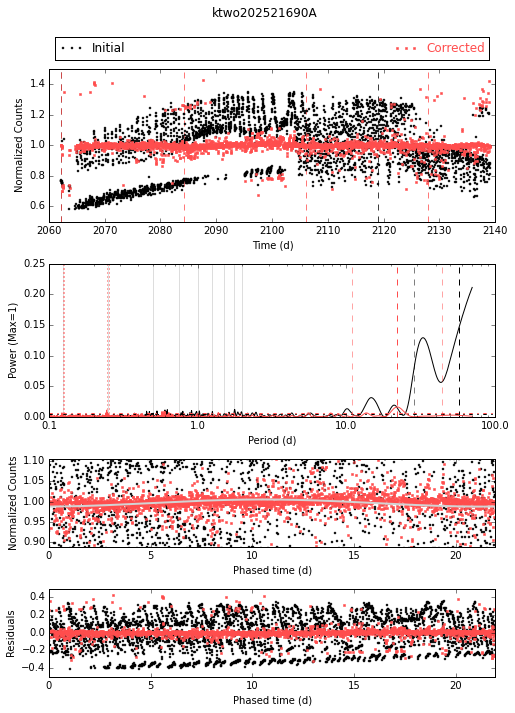

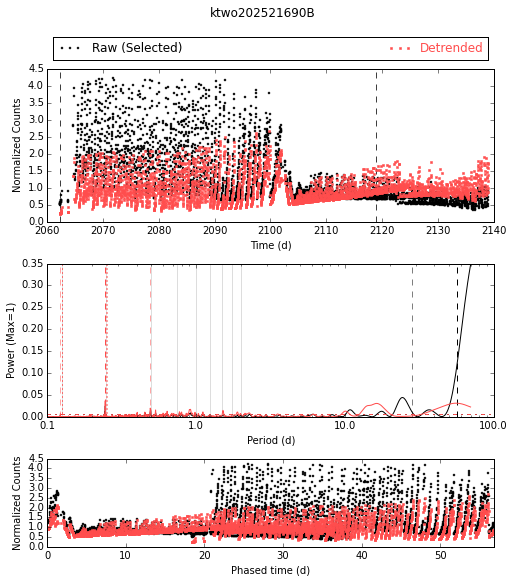

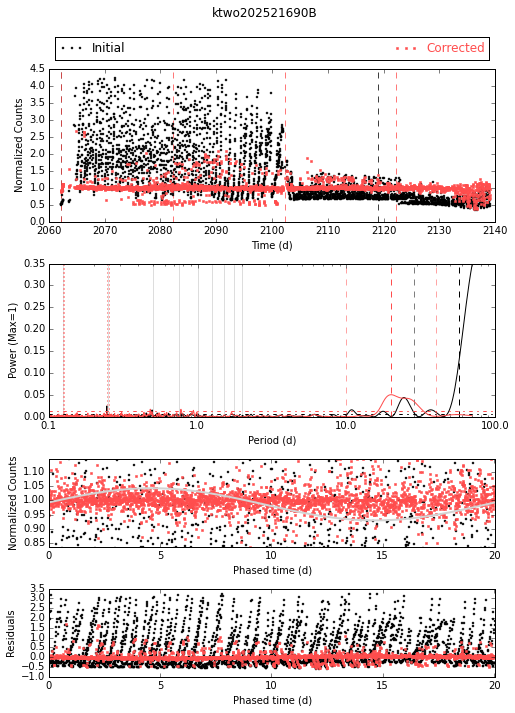

In [44]:
lc1 = lc.LightCurve(times, flux1, np.ones_like(flux1)*0.01, pos1[:,0], pos1[:,1], name="ktwo202521690A",
                    detrend_kwargs={"kind":"supersmoother","phaser":10})
lc2 = lc.LightCurve(times, flux2, np.ones_like(flux2)*0.01, pos2[:,0], pos2[:,1], name="ktwo202521690B",
                    detrend_kwargs={"kind":"supersmoother","phaser":10})

lc1.choose_initial()
lc1.correct_and_fit()

lc2.choose_initial()
lc2.correct_and_fit()

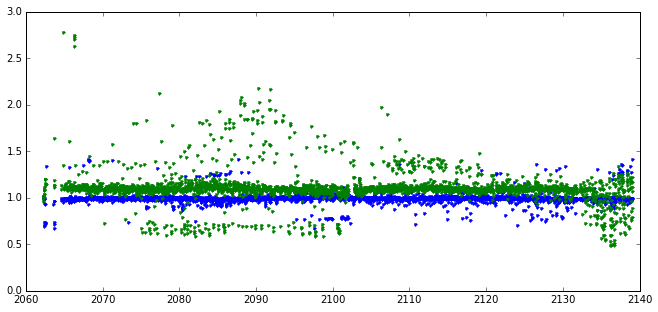

In [45]:
plt.figure(figsize=(11,5))
plt.plot(lc1.time, lc1.corrected_flux, '.')
plt.plot(lc2.time, lc2.corrected_flux+0.1,  '.')
#plt.ylim(45000,105000)